# Preamable

> Download and extract data for notebook execution.

The cell below prepares the Google Colab environment for execution. It will download our dataset and the FLIM-Weights, which we will use in this notebook.

In [73]:
import requests
from io import BytesIO
from zipfile import ZipFile
import os

def download_and_extract_zip(url, extract_path):
  response = requests.get(url, stream=True)
  response.raise_for_status()  # Raise an exception for bad status codes

  with ZipFile(BytesIO(response.content)) as zip_file:
    zip_file.extractall(extract_path)

if not os.path.exists("./parasites"):
  google_drive_url = "https://drive.usercontent.google.com/download?id=1Uwi8LYXYNnCp2brnuD49JrrWTrv_2HII&export=download&authuser=2&confirm=yes"
  download_and_extract_zip(google_drive_url, "./")
else:
  print("[INFO] Data already downloaded")

[INFO] Data already downloaded


# Exploring FLIM Towards Semantic Segmentation

> This notebook covers the necessary steps to experiment with a FLIM and a U-Net architecture, visualizing its activations. We will use FLIM to design a convolutional encoder.

We will approach the following:

1. Split our data into training and testing;
2. Configure a dataset;
3. Configure our dataset as a data loader to provide data ingestion during the training phase;
4. Define a fully convolutional network (U-Net);
5. Define a method to load FLIM-Encoder into our U-Net model;
6. Define a training loop and train our model;
     1. Define a learning rate scheduler;
     2. Training.
7. Define a testing loop, load our best model, and test it.

## 1. Split data into training and testing sets

First, we will define our dataset and then explore the parasite egg dataset towards 2D segmentation. The eggs are from Schistosoma Mansoni. The cell below imports the necessary libraries.

In [74]:
# Necessary libraries
from pathlib import Path, PosixPath
import os
from tqdm import tqdm
from typing import List, Union
import json

from PIL import ImageOps
from tifffile import imsave
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchsummary import summary

from skimage.color import lab2rgb

First, we need to define the path to our dataset. We are using the reshaped parasite dataset (images and labels have a shape of 240x240 pixels with three channels). To run our experiments, we need to use either a GPU (DEVICE) or a CPU ("cpu"); for such, we set the DEVICE variable.

We will also define the path to a JSON file specifying our encoder architecture and a folder with our encoder's weights. The `MODEL_FOLDER` variable specifies where we will save our outputs (models and predictions).

In [75]:
DATA_PATH = Path("parasites/data/")
ORIG_PATH = DATA_PATH / Path("orig")
LABELS_PATH = DATA_PATH / Path("label")
DEVICE = "cuda"

# Run FLIM Model
FLIM_PATH = Path("parasites/flim_data")
ARCH_JSON = Path(
    FLIM_PATH / Path("arch_sample.json")
)
WEIGHTS_PATH = Path(
    FLIM_PATH / Path("bofp_model")
)

# Reads architecture dict to define our network
with open(ARCH_JSON, "r") as json_data:
    arch_description = json.load(json_data)

MODEL_FOLDER = Path("sample_flim_model/")

Here, we also set the number of training epochs, our learning rate, and a loss function.

As we are using a FLIM Encoder, we also set whether to freeze it and use a learning rate scheduler.

In [76]:
# Training parameters
EPOCHS=50
LR=1e-2
LOSS="dice_focal"
FREEZE_ENCODER=True
USE_LR_SCHEDULER=False

Our dataset contains 100 images. We will divide it further into training and testing images. We will use 70% to train (70) and 30% to test (30) the model. You may modify the n_train variable (currently derived using 70% — 0.7 —to adjust the train and test size).

In [77]:
images = os.listdir(ORIG_PATH)
images.sort()
labels = images
print(f"N images {len(images)}")

# 70% of train and 30% of test
n_train = int((0.7 * len(images)))

# Train Data (File Names)
train_images = images[:n_train]
train_labels = images[:n_train]
# Test Data (File Names)
test_images = images[n_train:]
test_labels = images[n_train:]

print(f"{len(train_images)} training images")
print(f"{len(test_images)} testing images")

N images 100
70 training images
30 testing images


## 2. Configure a dataset

Now, we need to define the Dataset class. It must:

- Enable training and testing with a single image (If we want to train with a single image - Overfit). In this case, we set the parameter `image_id` to a number (e.g., 0);
- Enable training and testing using the data splits. In this case, we set the parameter `image_id` to `None`.

First, to efficiently load LAB images, we will use our C library (ift) through a Python wrapper ([pyift](https://github.com/LIDS-UNICAMP/pyift)). The cell below executes the following:

1. We install the pyift wheel (Downloaded from Google Drive)
2. We create a symbolic link to the pyift.so

> IMPORTANT: Comment if it is not your first run and you do not want to install pyift!

In [78]:
import sys

if not os.path.exists("./pyift_whl"):
  google_drive_url = "https://drive.usercontent.google.com/download?id=1ddlcSqwli4UIFlJvqhVLUc8kduFlsXDj&export=download&authuser=2&confirm=yes"
  download_and_extract_zip(google_drive_url, "./")
else:
  print("[INFO] Pyift folder already downloaded")

python_version = sys.version_info
sub_version = python_version.minor

# Install the whl located on data
whl_path = f"pyift_whl/3_{sub_version}/pyift-0.1-cp3{sub_version}-cp3{sub_version}-linux_x86_64.whl"
!python -m pip install $whl_path

# Get path to site-packages
import site
site_packages_path = site.getsitepackages()[0]
# Get absolute path
abs_path = os.path.realpath(f"pyift_whl/3_{sub_version}/pyift")

# Create Symbolick Link
!ln -s $abs_path/_pyift.*.so $site_packages_path/pyift/

[INFO] Pyift folder already downloaded
Processing ./pyift_whl/3_10/pyift-0.1-cp310-cp310-linux_x86_64.whl
pyift is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
ln: failed to create symbolic link '/usr/local/lib/python3.10/dist-packages/pyift/_pyift.cpython-310-x86_64-linux-gnu.so': File exists


We start by importing the necessary libraries as pyift to work with images in the LAB space.

In [79]:
import pyift.pyift as ift

In [80]:
class SegDataset(Dataset):
    def __init__(
        self,
        images_path: PosixPath, # Path to images
        labels_path: PosixPath, # Path to labels
        images: List[str], # List of images
        labels: List[str], # List of labels
        image_id: int = None # Image ID if training with a single image
    ):
        self.images_path = [images_path / Path(image) for image in images]
        self.labels_path = [labels_path / Path(label) for label in labels]
        self.image_id = image_id

        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float32)
        ])

    def __len__(self):
        # If image id not provided, we are training with the whole dataset
        if self.image_id == None:
            return len(self.images_path)
        else:
            return 1

    def load_image(self, path):
        image = ift.ReadImageByExt(path)
        mimage = ift.ImageToMImage(image, color_space=ift.LABNorm2_CSPACE)
        image = mimage.AsNumPy()
        image = image.squeeze()

        return image

    def __getitem__(self, idx):
        if self.image_id == None:
            image_path = self.images_path[idx]
            label_path = self.labels_path[idx]
        else:
            image_path = self.images_path[self.image_id]
            label_path = self.labels_path[self.image_id]

        image = self.load_image(str(image_path))
        image = self.transforms(image)

        label = ImageOps.grayscale(Image.open(label_path))
        label = self.transforms(label)

        return image, label

Now, we create our dataset and a method (`visualize_dataset_item`) to visualize our dataset's given data (input image and label). The `__getitem__` method enables us to use our dataset to read a given image and label (`idx` parameter).

In [81]:
# DATASETS - TRAIN AND TEST
train_dataset = SegDataset(
    images_path=ORIG_PATH,
    labels_path=LABELS_PATH,
    images=train_images,
    labels=train_labels,
    image_id=None
)
test_dataset = SegDataset(
    images_path=ORIG_PATH,
    labels_path=LABELS_PATH,
    images=test_images,
    labels=test_labels,
    image_id=None
)

In [82]:
def visualize_dataset_item(dataset, item):
    img, label = dataset.__getitem__(item)
    img = img.permute(1, 2, 0)
    img[:,:, 0] = img[:,:, 0] * 99.998337
    img[:,:, 1] = img[:,:, 1] * (86.182236 + 98.258614) - 86.182236
    img[:,:, 2] = img[:,:, 2] * (107.867744 + 94.481682) - 107.867744
    img = lab2rgb(img)
    print("Foreground shape => ", img.shape)
    print("label shape => ", label.shape)

    plt.subplot(121)
    plt.yticks([]),plt.xticks([])
    plt.title("Image")
    plt.imshow(img)
    plt.subplot(122)
    plt.yticks([]),plt.xticks([])
    plt.title("Label")
    plt.imshow(label[0], cmap="gray", vmin=0, vmax=1)

In [83]:
visualize_dataset_item(
    dataset=train_dataset,
    item=3
)

Foreground shape =>  (400, 400, 3)
label shape =>  torch.Size([1, 400, 400])


## 3. Configure our dataset as a dataloader

Through PyTorch data loader ([`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)), we configure our dataset as a data loader by using:

- A Dataset (Our Train and Test datasets);
- A batch size (Number of images used to update the model's parameters);
- If we want to shuffle our data at each epoch (We see images in different orders for each epoch).

In [84]:
# DATALOADERS - TRAIN AND TEST
train_dataloader = DataLoader(
    train_dataset, batch_size=8, shuffle=True
)
test_dataloader  = DataLoader(
    test_dataset, batch_size=1, shuffle=False
)

# Visualizes shape of a batch sampled from train dataloder
sample_train_images, sample_train_labels = next(iter(train_dataloader))
print("Images shape => ", sample_train_images.shape)
print("Labels shape => ", sample_train_labels.shape)

Images shape =>  torch.Size([8, 3, 400, 400])
Labels shape =>  torch.Size([8, 1, 400, 400])


Let us visualize a batch of input training data:

In [85]:
def visualize_batch(dataloader):
    batch_images, batch_labels = next(iter(dataloader))
    batch_size = batch_images.shape[0]

    fig, axes = plt.subplots(batch_size, 2, figsize=(8,30))
    for idx in range(batch_size):
        image = batch_images[idx]
        label = batch_labels[idx]
        image = image.permute(1, 2, 0)
        image[:,:, 0] = image[:,:, 0] * 99.998337
        image[:,:, 1] = image[:,:, 1] * (86.182236 + 98.258614) - 86.182236
        image[:,:, 2] = image[:,:, 2] * (107.867744 + 94.481682) - 107.867744
        image = lab2rgb(image)

        # Plot Data
        axes[idx][0].set_yticks([]),axes[idx][0].set_xticks([])
        axes[idx][0].set_title("Image")
        axes[idx][0].imshow(image)
        axes[idx][1].set_yticks([]),axes[idx][1].set_xticks([])
        axes[idx][1].set_title("Label")
        axes[idx][1].imshow(label[0], cmap="gray", vmin=0, vmax=1)

In [86]:
visualize_batch(dataloader=train_dataloader)

## 4. Define a fully convolutional network (U-Net)

Now, we have a dataloader working. It is responsible for feeding data, both the input image and the parasite egg's segmentation mask, to a deep learning model. Given an input image, we expect that our model will learn to segment the parasite egg, if any.

The following cells define our deep-learning model, a U-Net architecture (**see the image below**). We also enable our model to store the activation maps for visual analysis.

U-Net architectures have two parts: an encoder (left) and a decoder (right). The encoder extracts image features at different levels while the encoder combines those extracted features to detect and segment.

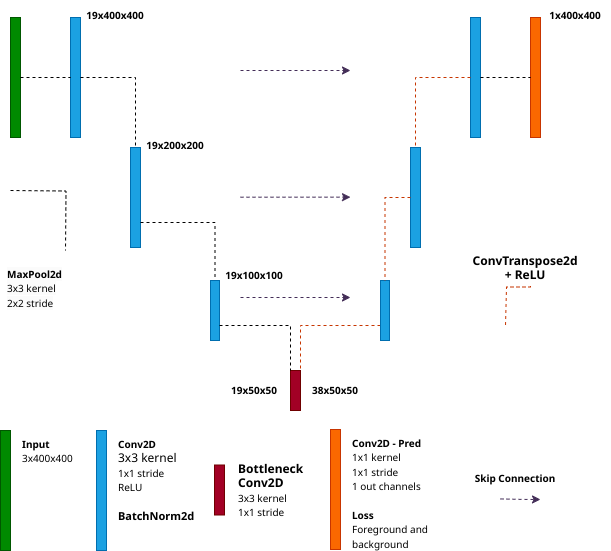

Let us first define some methods to help us:

- **up_conv:** Implements our **ConvTranspose2d** convolutions, responsible for upsampling our features in the decoder;
- **Conv:** Implements our **Conv2D** in decoders;
- **init_weights:** Initializes our model's parameters, using Xavier uniform for convolution's weights and setting biases to 0.01.

In [87]:
# Upsamples input feature map
def get_up_conv(in_channels, out_channels, kernel_size=2, padding=0, stride=2, output_padding=0):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride, output_padding=output_padding),
        nn.ReLU(inplace=True)
    )

# Defines convolutional blocks for our decoder
def get_conv_block(in_channels, out_channels, kernel_size, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

# Initializes kernel weights
def init_weights(m):
    if (isinstance(m,nn.Conv2d) or (isinstance(m,nn.ConvTranspose2d))):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

Now, the class UNet defines our U-Net architecture:

1. On the **__init__** method, we first set a random_seed to guarantee reproducibility. Then, we define our encoder blocks (block1, block2, and block3), our bottleneck, and finally, our decoder (up_convs + dec_convs and the pred convolution, which outputs our segmentation mask);
2. Our **forward** method is responsible for passing the input image through the model architecture until we get the parasite egg's mask at the end;
3. **write_activation** and **save_activations** saves activations of each network block for visual inspection (If we set the `activations_path`. If `activations_path` is `None`, it will not save, to avoid excessive disk usage, and decrease training times);
4. **save_curves** will save the learning curves of our models at the end of our training loop, displaying accuracy, loss, and dice across the whole training (save the curvers to the path indicated by `model_folder`);
5. **save_model_weights** save the model weights a `model_folder`;
6. **load_best_model** loads the best-trained model (i.e., lower loss).

To initialize a U-Net model, we must set the following parameters:

- `in_channels:` The number of channels of our input (e.g., 3 for RGB and 1 for Gray);
- `n_kernels:` A list of 3 integer values specifying the number of kernels for each convolutional block (e.g., [8, 16, 32]). Those values are used to define both encoder and decoder convolutional blocks;
- `kernel_sizes:` A list of 3 integer values, specifying the kernels' size for each convolutional block (e.g., [3, 3, 3]);
- `model_folder`: An output folder to save model weights and learning curves;
- `activations_path:` A path to save each convolutional block activation. After training, one could navigate to that folder to visualize what features the model is extracting. If `None`, does not save activations.

> IMPORTANT: Saving activations increases training time, so it could be turned off by not setting the `activations_path` or setting it as `None` (Standard Value).

In [88]:
class UNet(nn.Module):
    def __init__(
            self, in_channels: int, # RGB or LAB -> 3 Channels
            n_kernels: List[int], # N Kernels by conv block
            kernel_sizes: List[int], # Kernel sizes by conv block
            bottleneck_size: int, # Kernel size for bottleneck
            model_folder: PosixPath, # Path to save model weights and learning curves
            activations_path: PosixPath = None # Path to save activations
    ) -> None:
        super().__init__()

        # Sets torch seed to guaratee Reproducibility
        random_seed = 7
        torch.manual_seed(random_seed)
        torch.cuda.manual_seed(random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        self.activations_path = activations_path
        self.model_folder = model_folder
        os.makedirs(self.model_folder, exist_ok=True)
        self.weights_folder = model_folder / Path("weights")
        os.makedirs(self.weights_folder, exist_ok=True)

        # Encoder Convolutional Blocks
        self.block1 = get_conv_block(
            in_channels=in_channels,
            out_channels=n_kernels[0],
            kernel_size=kernel_sizes[0],
            padding=kernel_sizes[0] // 2
        )
        self.block2 = get_conv_block(
            in_channels=n_kernels[0],
            out_channels=n_kernels[1],
            kernel_size=kernel_sizes[1],
            padding=kernel_sizes[1] // 2
        )
        self.block3 = get_conv_block(
            in_channels=n_kernels[1],
            out_channels=n_kernels[2],
            kernel_size=kernel_sizes[2],
            padding=kernel_sizes[2] // 2
        )
        self.max_pool = nn.MaxPool2d(
            kernel_size=3, stride=2, padding=1
        )

        # Bottleneck
        self.bottleneck = nn.Conv2d(
            in_channels=n_kernels[2], out_channels=2*n_kernels[2],
            kernel_size=bottleneck_size, stride=1, padding=bottleneck_size//2
        )

        # Decoder
        self.up_conv1 = get_up_conv(
            in_channels=2*n_kernels[2], out_channels=n_kernels[2]
        )
        self.dec_conv1 = get_conv_block(
            in_channels=2*n_kernels[2], out_channels=n_kernels[2],
            kernel_size=kernel_sizes[2], padding=kernel_sizes[2] // 2
        )
        self.up_conv2 = get_up_conv(
            in_channels=n_kernels[2], out_channels=n_kernels[1]
        )
        self.dec_conv2 = get_conv_block(
            in_channels=2*n_kernels[1], out_channels=n_kernels[1],
            kernel_size=kernel_sizes[1], padding=kernel_sizes[1] // 2
        )
        self.up_conv3 = get_up_conv(
            in_channels=n_kernels[1], out_channels=n_kernels[0]
        )
        self.dec_conv3 = get_conv_block(
            in_channels=2*n_kernels[0], out_channels=n_kernels[0],
            kernel_size=kernel_sizes[0], padding=kernel_sizes[0] // 2
        )
        self.pred = nn.Conv2d(
            in_channels=n_kernels[0], out_channels=1, kernel_size=1
        )

        # Initializes weights
        self.block1.apply(init_weights)
        self.block2.apply(init_weights)
        self.block3.apply(init_weights)
        self.up_conv1.apply(init_weights)
        self.dec_conv1.apply(init_weights)
        self.up_conv2.apply(init_weights)
        self.dec_conv2.apply(init_weights)
        self.up_conv3.apply(init_weights)
        self.dec_conv3.apply(init_weights)
        self.pred.apply(init_weights)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Dictionary to keep track of activations
        self.activations = {"encoder": [], "decoder": []}

        # Encoder
        x1 = self.block1(x)
        self.activations["encoder"].append(x1)
        x2 = self.block2(self.max_pool(x1))
        self.activations["encoder"].append(x2)
        x3 = self.block3(self.max_pool(x2))
        self.activations["encoder"].append(x3)

        # Bottleneck
        bottleneck = self.bottleneck(self.max_pool(x3))

        # Decoder - torch.cat performs skip connections on decoder
        x = self.up_conv1(bottleneck)
        x = torch.cat([x, x3], dim=1)
        x = self.dec_conv1(x)
        self.activations["decoder"].append(x)
        x = self.up_conv2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec_conv2(x)
        self.activations["decoder"].append(x)
        x = self.up_conv3(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec_conv3(x)
        self.activations["decoder"].append(x)
        x = self.pred(x)

        return x

    def write_activation(
        self, image: np.ndarray, path: PosixPath, reshape: bool=False
    ) -> None:
        max_img = np.max(image)
        min_img = np.min(image)
        if (min_img != max_img):
            image = 255 * (image - min_img) / (max_img - min_img)
        image = image.astype(np.uint8)

        image = Image.fromarray(image)
        if reshape:
            image = image.resize((240, 240), Image.Resampling.NEAREST)
        image.save(path)

    @torch.no_grad()
    def save_activations(self, epoch: int, data_loader) -> None:
        # Save encoder activations
        activations_path = self.activations_path / Path(f"epoch_{epoch}")

        # Save activations for each image
        print("[INFO] Saving activations!")
        images_path = data_loader.dataset.images_path
        for image_path in tqdm(images_path):
            image_name = os.path.basename(image_path)
            saving_path = activations_path / Path(image_name.replace(".png","")) / Path("encoder")
            saving_path_reshape = activations_path / Path(image_name.replace(".png","")) / Path("encoder_reshape")
            os.makedirs(saving_path, exist_ok=True)
            os.makedirs(saving_path_reshape, exist_ok=True)

            image_data = data_loader.dataset.image_transforms(Image.open(image_path))
            # Adds batch dimension
            image_data = torch.unsqueeze(image_data, dim=0)
            image_data = image_data.to(DEVICE)
            self.to(DEVICE)
            self.forward(image_data)

            # Save encoder activations
            for actv_idx, activations in enumerate(self.activations["encoder"]):
                activations = activations.cpu().detach().numpy()
                for ch_idx in range(activations.shape[1]):
                    channel_activations = activations[0, ch_idx, ...]

                    filename = Path(f"layer_{actv_idx}_ch_{ch_idx}.png")
                    # Save normal size image
                    self.write_activation(
                        channel_activations, saving_path / filename
                    )
                    # Reshape to input size
                    self.write_activation(
                        channel_activations, saving_path_reshape / filename, True
                )

            # Save decoder activations
            saving_path = activations_path / Path(image_name.replace(".png","")) / Path("decoder")
            saving_path_reshape = activations_path / Path(image_name.replace(".png","")) / Path("decoder_reshape")
            os.makedirs(saving_path, exist_ok=True)
            os.makedirs(saving_path_reshape, exist_ok=True)
            for actv_idx, activations in enumerate(self.activations["decoder"]):
                activations = activations.cpu().detach().numpy()
                for ch_idx in range(activations.shape[1]):
                    channel_activations = activations[0, ch_idx, ...]

                    filename = Path(f"layer_{actv_idx}_ch_{ch_idx}.png")
                    # Save normal size imagace
                    self.write_activation(
                        channel_activations, saving_path / filename
                    )
                    # Reshape to input size
                    self.write_activation(
                        channel_activations, saving_path_reshape / filename, True
                    )

        # Save model weights
        torch.save(self.state_dict(), activations_path / Path("model.pth"))

    def load_best_model(self) -> None:
        weight_files = os.listdir(self.weights_folder)
        losses = [file.split("_")[3] for file in weight_files]
        best_weight_file = weight_files[np.argmin(losses)]
        best_weight_path = self.weights_folder / Path(best_weight_file)
        self.load_state_dict(
            torch.load(best_weight_path, weights_only=True)
        )
        print(f"Load weights from {best_weight_file}")

    def save_model_weights(
        self, epoch: int, loss: float, accuracy: float
    ) -> None:
        weights_path = self.weights_folder / Path(f"epoch_{epoch}_loss_{loss:.3}_{accuracy:.3}.pth")
        torch.save(
            self.state_dict(), weights_path
        )

    def save_curves(
        self, losses: List[float], accuracies: List[float]
    ) -> None:
        plt.ioff()
        epochs = [e + 1 for e in range(len(losses))]

        # Save loss curve
        fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f6f6f6')
        line, = ax.plot(epochs, losses, color='#FF5733', linewidth=3, label='Training Loss')
        gradient_fill = ax.fill_between(epochs, losses, color='#FF5733', alpha=0.3)
        ax.set_xlabel('Epochs', fontsize=14, color='#555555')
        ax.set_ylabel('Loss', fontsize=14, color='#555555')
        ax.set_title('Training Loss Curve', fontsize=18, fontweight='bold', color='#333333')
        savefig_path = self.model_folder / Path("loss.png")
        plt.savefig(savefig_path)
        plt.close()

        # Save Accuracy curve
        fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f6f6f6')
        line, = ax.plot(epochs, accuracies, color='#FF5733', linewidth=3, label='Training Accuracy')
        gradient_fill = ax.fill_between(epochs, accuracies, color='#FF5733', alpha=0.3)
        ax.set_xlabel('Epochs', fontsize=14, color='#555555')
        ax.set_ylabel('Accuracy', fontsize=14, color='#555555')
        ax.set_title('Accuracy Curve', fontsize=18, fontweight='bold', color='#333333')
        savefig_path = self.model_folder / Path("accuracy.png")
        plt.savefig(savefig_path)
        plt.close()

Let us now define a model and print its architecture:

In [89]:
# If necessary install torchview
!python -m pip install torchview

In [90]:
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')

'png'

In [91]:
unet = UNet(
    in_channels=3,
    n_kernels=[
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ],
    kernel_sizes=[
        arch_description["layer1"]["conv"]["kernel_size"][0],
        arch_description["layer2"]["conv"]["kernel_size"][0],
        arch_description["layer3"]["conv"]["kernel_size"][0]
    ],
    bottleneck_size=3,
    model_folder=MODEL_FOLDER,
    activations_path=None
).to(DEVICE)

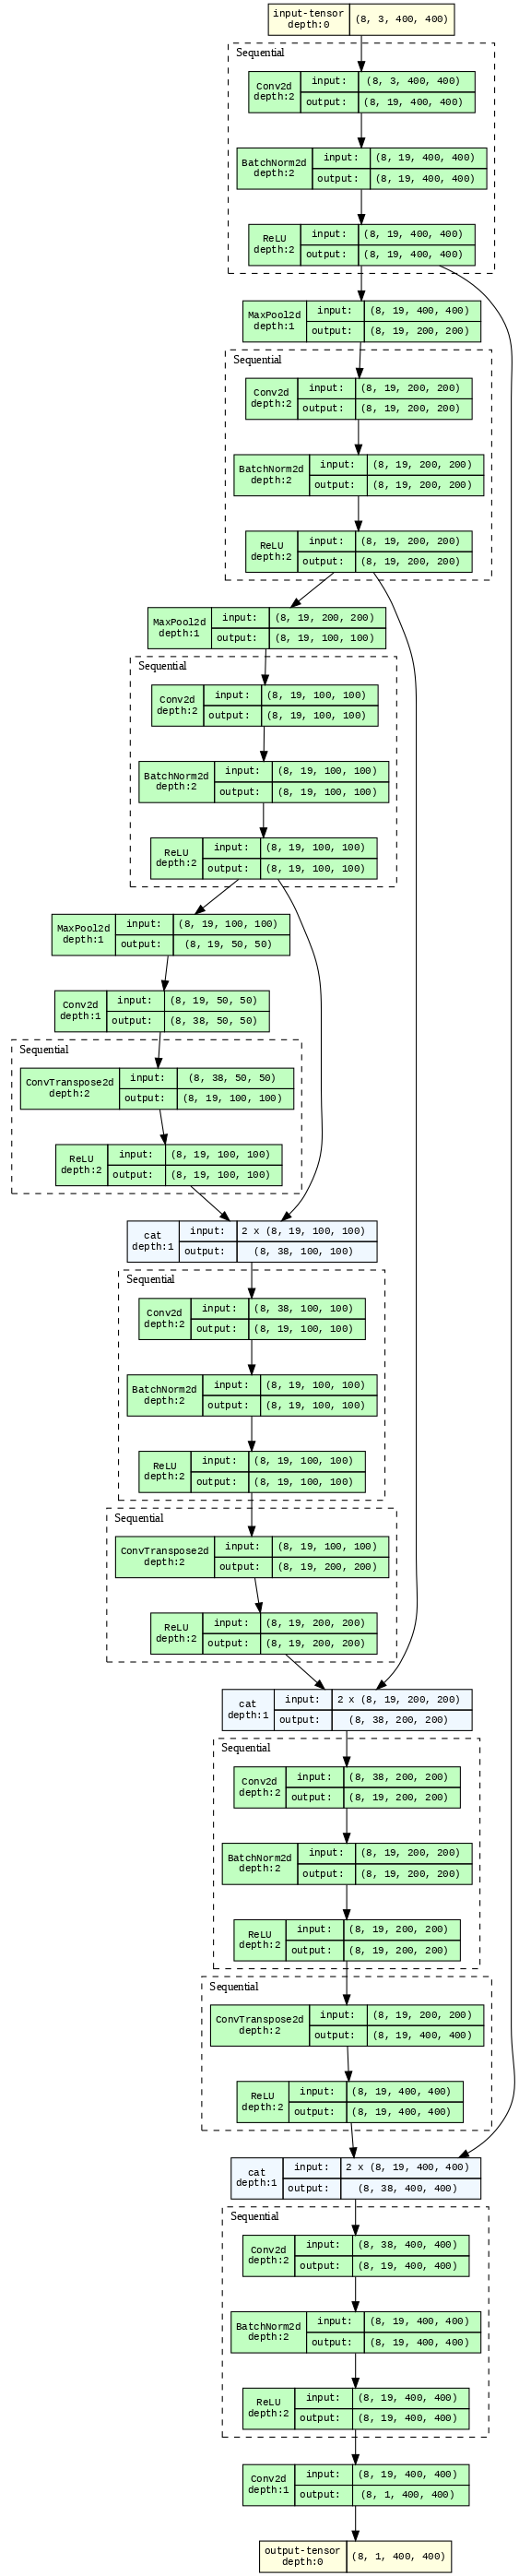

In [92]:
model_graph = draw_graph(
    unet, input_size=(8,3,400,400), expand_nested=True, save_graph=True, filename=MODEL_FOLDER / Path("model_arch")
)
model_graph.visual_graph

## 5. Define a method to load FLIM-Encoder into our U-Net model

Additionally, as we will use a FLIM Encoder as our U-Net encoder, we define methods to load the FLIM Encoder's weight into the U-Net encoder.

The method `load_FLIM_encoder`, receives as parameters:

- `model`: Our U-Net model;
- `arch_json`: The path to a JSON file describing our FLIM-Encoder;
- `weights_path`: The path to a folder with the FLIM-Encoder's weights;
- `channels`: A list specifying the number of input channels (e.g., 3 for RGB) and the number of filters for each encoder convolutional block.

In [93]:
def get_bias(bias_path: PosixPath) -> np.ndarray:
    with open(bias_path, "r") as file:
        n_kernels = file.readline()
        bias = file.readline().strip().split(" ")

    bias = np.array(bias).astype(np.float32)

    return bias


def shift_weights(weights: np.ndarray, kernel_size: int, in_channels: int) -> np.ndarray:

    nkernels = weights.shape[1]

    shifted_weights = np.zeros((nkernels,in_channels,kernel_size[1],kernel_size[0]))

    for k in range(nkernels):
        for channel in range(in_channels):
            i = channel
            for row in range(kernel_size[1]):
                for col in range(kernel_size[0]):
                    shifted_weights[k][channel][row][col] = weights[i][k]
                    i = i + in_channels

    return shifted_weights


def get_weights(kernel_path: PosixPath,  kernel_size: int, in_channels: int) -> np.ndarray:
    weights = np.load(kernel_path)
    weights = shift_weights(weights, kernel_size, in_channels)

    return weights

def load_FLIM_encoder(model: UNet, arch_json: PosixPath, weights_path: PosixPath, channels: List[int]) -> None:
    with open(arch_json, "r") as json_data:
        arch_description = json.load(json_data)

    n_layers = arch_description["nlayers"]

    in_channels = channels[0]
    print("[INFO] Loading FLIM Encoder")
    for n in range(1, n_layers + 1):
        out_channels = channels[n]

        print(f"[INFO] Loading Layer {n} weights")
        # Gets each encoder Block to set its weights and biases
        model_block = getattr(model, f"block{n}")

        # Sets its biases
        bias_path = weights_path / Path(f"conv{n}-bias.txt")
        kernel_path = weights_path / Path(f"conv{n}-kernels.npy")
        # Get biases and set to model - Accessing conv block biases
        bias = get_bias(bias_path)
        bias = nn.Parameter(torch.from_numpy(bias).float())
        model_block[0].bias.data = bias.to(DEVICE)

        # Get kernel weights and set to model - Accessing conv block weights
        kernel_size = arch_description[f"layer{n}"]["conv"]["kernel_size"]
        weights = get_weights(kernel_path, kernel_size, in_channels)
        weights = nn.Parameter(torch.from_numpy(weights).float())
        model_block[0].weight.data = weights.to(DEVICE)

        in_channels = channels[n]

In [94]:
load_FLIM_encoder(
    model=unet,
    arch_json=ARCH_JSON,
    weights_path=WEIGHTS_PATH,
    channels=[
        3,
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

summary(unet, (3,240,240))

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights
[INFO] Loading Layer 3 weights
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 19, 240, 240]             532
       BatchNorm2d-2         [-1, 19, 240, 240]              38
              ReLU-3         [-1, 19, 240, 240]               0
         MaxPool2d-4         [-1, 19, 120, 120]               0
            Conv2d-5         [-1, 19, 120, 120]           3,268
       BatchNorm2d-6         [-1, 19, 120, 120]              38
              ReLU-7         [-1, 19, 120, 120]               0
         MaxPool2d-8           [-1, 19, 60, 60]               0
            Conv2d-9           [-1, 19, 60, 60]           3,268
      BatchNorm2d-10           [-1, 19, 60, 60]              38
             ReLU-11           [-1, 19, 60, 60]               0
        MaxPool2d-12           [-1, 19, 30, 30

## 6. Define a training loop and train our model

### A. Define a learning rate scheduler

Fine-tuning an architecture already trained with an untrained decoder running the first epochs with a small learning rate is helpful. As the first epochs using an untrained decoder will result in higher errors, a lower learning rate scheduler avoids "forgetting" what the FLIM-Encoder has already learned.

The cell below shows how to define and use a learning rate scheduler.

In [95]:
# Import necessary libraries
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

In [96]:
# create a simple model
model = nn.Sequential(
    nn.Linear(34, 34),
    nn.ReLU(),
    nn.Linear(34, 1),
    nn.Sigmoid()
)

lr=1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()
# Start Factor of the optimizer learning rate
# End factor of the optimizer learning rate
# Total iterations to increase from Start to End Factor
scheduler = lr_scheduler.LinearLR(
    optimizer, start_factor=1e-3, end_factor=1,
    total_iters=400
)

# List to plot our results
lrs = []
epochs = []

for epoch in range(1000):
    lr = scheduler.get_last_lr()
    epochs.append(epoch+1)
    lrs.append(lr)
    optimizer.step()
    scheduler.step()

The cell below shows our learning rate across 1000 training epochs.

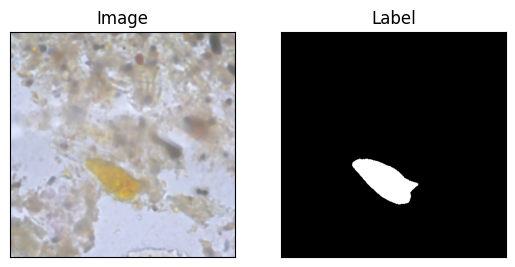

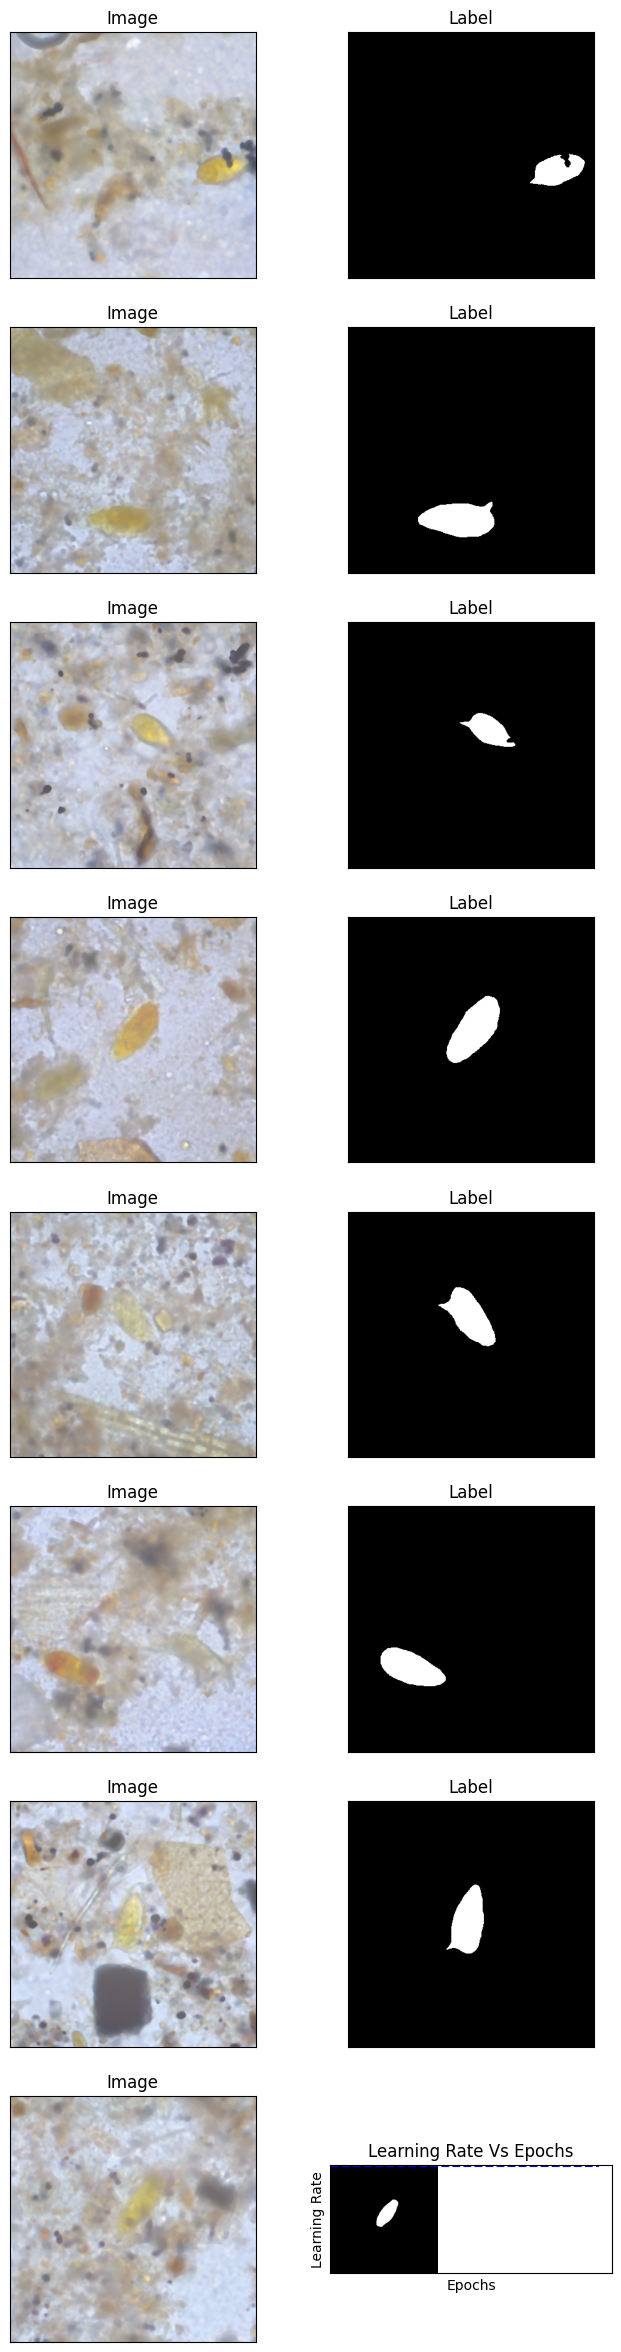

In [97]:
plt.plot(epochs, lrs, "b--")
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Vs Epochs")
plt.show()

### B. Training

We have everything prepared in our pipeline; we lack a training loop that will feed data from the data loader to our model, use the model's prediction to compute loss, and update the model's parameter.

Furthermore, as we are using a FLIM-Encoder, we want our training loop to have two additional features:

- **Freeze the Encoder's Weights**: In this case, we do not learn the encoder; our training loop updates the decoder's parameters.
- **Train with a Learning Rate Scheduler:** We use a learning rate scheduler to optimize the encoder's weights.

First, we import the necessary libraries.

In [98]:
# If necessary install monai
!python -m pip install monai

In [99]:
from torch import optim
from torchsummary import summary
import monai
from monai.losses import DiceLoss, DiceFocalLoss
import cv2

Secondly, we define a loss function which we want to optimize. Those loss functions were calculated by comparing the model's prediction with the ground-truth segmentation mask. To optimize those loss functions is to produce better segmentation masks.

Below, we made available the following losses:

- [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss)
- [BCE](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss)
- [DiceLoss](https://docs.monai.io/en/stable/losses.html)
- [DiceFocalLoss](https://docs.monai.io/en/stable/losses.html#dicefocalloss)

> See our slide decks and the link provided for further details.

In [100]:
loss_fuctions = {
    "mse": nn.MSELoss(),
    "bce": nn.BCELoss(),
    "dice": DiceLoss(),
    "dice_focal": DiceFocalLoss()
}

Finally, we define our training loop. For such, we must provide:

- The number of epochs to train our model;
- Our U-Net model;
- A data loader;
- The name of our loss_function (e.g., "mse," "bce");
- Our learning rate (lr), which controls the size of updates in the models' parameters. A too-high value will cause instability, while a too-low value will result in slower training;
- The `freeze_encoder` parameter. `False` allows our training loop to update the encoder's weights, while `True` does not allow it.
- The `use_lr_scheduler` parameter. `True` allows our training loop to use a learning rate scheduler, while `True` uses a fixed learning rate.
- The `iters_scheduler` indicates the number of epochs to reach the target learning rate.

> The `n_save_activations` variable controls when we save our convolution activations. Currently, it writes activations for every 100 epochs. However, saving activations takes time and could delay the training process. Set it to `n_save_activations=None` to turn off saving activations.

In [101]:
def train_loop(
        epochs, model, dataloader, lr, loss_function,
        freeze_encoder=False, use_lr_scheduler=False, iters_scheduler=10,
        n_save_activations=100
    ):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    if use_lr_scheduler:
        scheduler = lr_scheduler.LinearLR(
          optimizer, start_factor=1e-2, end_factor=1, total_iters=EPOCHS//4, verbose=False
        )
    model.to(DEVICE)
    epoch_losses = []
    epoch_accuracies = []

    # Freeze encoder weights
    if freeze_encoder:
        model.block1.requires_grad_(False)
        model.block1.trainable = False
        model.block2.requires_grad_(False)
        model.block2.trainable = False

    for epoch in range(epochs):
        losses = []
        accuracies = []
        for batch in dataloader: # In our case, a single image, or 3
            model.train()
            image, ground_truth = batch
            image = image.to(DEVICE)
            ground_truth = ground_truth.to(DEVICE)
            prediction = model(image)
            optimizer.zero_grad()

            # Computes loss and accuracy
            prediction = torch.sigmoid(prediction)
            loss_value = loss_function(prediction, ground_truth)

            accuracy = (
                (prediction > 0.5) == ground_truth
            ).float().mean()

            losses.append(loss_value)
            accuracies.append(accuracy)

            loss_value.backward()
            optimizer.step()

        # At the end of the epoch, we take a step in our LR Scheduler
        if use_lr_scheduler:
            scheduler.step()

        mean_loss = torch.mean(torch.Tensor(losses))
        mean_acc = torch.mean(torch.Tensor(accuracies))

        print(f"[{epoch + 1}/{epochs}] Avg Loss: {mean_loss.item()} | Avg Accuracy: {mean_acc.item()}")

        epoch_losses.append(mean_loss.item())
        epoch_accuracies.append(mean_acc.item())

        # Each 10 epoch verifyies if the model improved
        if ((epoch + 1) % 10) == 0:
            if epoch_losses[-1] < epoch_losses[-10]:
                model.save_model_weights(
                    epoch+1, epoch_losses[-1], epoch_accuracies[-1]
                )

        if model.activations_path != None:
            if ((epoch + 1) % n_save_activations) == 0:
                model.save_activations(epoch, dataloader)

    model.save_curves(epoch_losses, epoch_accuracies)

Then, we run our training loop, using the training data loader defined before:

In [102]:
train_loop(
    epochs=EPOCHS,
    model=unet,
    dataloader=train_dataloader,
    lr=LR,
    loss_function=loss_fuctions[LOSS],
    freeze_encoder=FREEZE_ENCODER,
    use_lr_scheduler=USE_LR_SCHEDULER
)

[1/50] Avg Loss: 1.2085996866226196 | Avg Accuracy: 0.7668417096138
[2/50] Avg Loss: 1.031313419342041 | Avg Accuracy: 0.9693984985351562
[3/50] Avg Loss: 0.8706557750701904 | Avg Accuracy: 0.9794939756393433
[4/50] Avg Loss: 0.6695835590362549 | Avg Accuracy: 0.9849745631217957
[5/50] Avg Loss: 0.5163366794586182 | Avg Accuracy: 0.9848345518112183
[6/50] Avg Loss: 0.4241679608821869 | Avg Accuracy: 0.987959623336792
[7/50] Avg Loss: 0.38780808448791504 | Avg Accuracy: 0.9898170828819275
[8/50] Avg Loss: 0.38120806217193604 | Avg Accuracy: 0.9891373515129089
[9/50] Avg Loss: 0.38296374678611755 | Avg Accuracy: 0.988532304763794
[10/50] Avg Loss: 0.37230002880096436 | Avg Accuracy: 0.9908534288406372
[11/50] Avg Loss: 0.37470734119415283 | Avg Accuracy: 0.9895347952842712
[12/50] Avg Loss: 0.34814348816871643 | Avg Accuracy: 0.9913294315338135
[13/50] Avg Loss: 0.344793438911438 | Avg Accuracy: 0.9911624193191528
[14/50] Avg Loss: 0.392252653837204 | Avg Accuracy: 0.9873977303504944
[15

## 7. Define a testing loop, load our best model, and test it.

First, we import the necessary libraries

In [103]:
# If necessary install medpy and torchmetrics
!python -m pip install medpy
!python -m pip install torchmetrics

In [104]:
from medpy.metric import binary
from torchmetrics import JaccardIndex
np.bool = np.bool_

The cells below define a method for using our trained model and predicting a segmentation map. We also compute metrics between the prediction map and the ground truth. The following metrics were used:

- [Accuracy](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html);
- [Dice](http://loli.github.io/medpy/generated/medpy.metric.binary.dc.html#medpy.metric.binary.dc);
- [Intersection-over-Union](https://torchmetrics.readthedocs.io/en/stable/classification/jaccard_index.html), also know as jaccard_index.

> It will also save the predictions to the `MODEL_FOLDER` folder.

In [105]:
# This code gets the trained model and execute inferences on the Dataloader
@torch.no_grad()
def predict_and_evaluate(
        model: UNet,
        data_loader:torch.utils.data.dataloader.DataLoader
    ):
    images_path = data_loader.dataset.images_path
    labels_path = data_loader.dataset.labels_path
    folder_to_save = model.model_folder / Path("0_preds")
    os.makedirs(folder_to_save, exist_ok=True)

    accuracies = []
    dices = []
    ious = []
    jaccard_index = JaccardIndex(num_classes=2, task="binary")

    for image_path, label_path in tqdm(zip(images_path, labels_path)):
        image = data_loader.dataset.load_image(str(image_path))
        image_data = data_loader.dataset.transforms(image)
        ground_truth = data_loader.dataset.transforms(
            ImageOps.grayscale(Image.open(label_path))
        )
        ground_truth = ground_truth.cpu().detach().numpy()[0]
        # Adds batch dimension
        image_data = torch.unsqueeze(image_data, dim=0)
        image_data = image_data.to(DEVICE)
        prediction = model(image_data)
        prediction = torch.sigmoid(prediction)

        image_name = os.path.basename(image_path)
        path_to_save = folder_to_save / Path(image_name)
        mask = np.zeros((400, 400), dtype=np.uint8)
        prediction = prediction.cpu().detach().numpy().squeeze()
        mask[prediction > 0.5] = 1

        accuracy = np.mean((mask == ground_truth).astype(np.float32))
        accuracies.append(accuracy)
        # Verifies if there is parasite eggs on images
        if np.any(ground_truth > 0):
            dice = binary.dc(mask, ground_truth)
            dices.append(dice)
            iou = jaccard_index(torch.Tensor(mask).long(), torch.Tensor(ground_truth).long())

            ious.append((iou.numpy()))
        else: # If not
            # If there is no parasite and our model predicted it, dice and iou equals 0
            if np.any(mask > 0):
                dices.append(0)
                ious.append(0)
            # If there is no parasite and our model do not predicted it, dice and iou equals 1 (100%)
            else:
                dices.append(1)
                ious.append(1)


        cv2.imwrite(
            str(path_to_save), mask * 255
        )

    accuracies = np.array(accuracies)
    dices = np.array(dices)
    ious = np.array(ious)

    print(f"[INFO] Avg Accuracy: {np.mean(accuracies)} +/- {np.std(accuracies)}")
    print(f"[INFO] Avg Dice: {np.mean(dices)} +/- {np.std(dices)}")
    print(f"[INFO] Avg IoU: {np.mean(ious)} +/- {np.std(ious)}")

Now, we can load the best-trained model and assess our results on both training and test data.

First, let us load our best weights:

In [106]:
unet.load_best_model()

Load weights from epoch_50_loss_0.296_0.993.pth


Finally, we run our testing method (`predict_and_evaluate`) for the trained model, using the training and testing data.

In [107]:
print("[INFO] Training Metrics")
predict_and_evaluate(model=unet, data_loader=train_dataloader)

[INFO] Training Metrics


70it [00:07,  9.87it/s]

[INFO] Avg Accuracy: 0.993785560131073 +/- 0.005021438002586365
[INFO] Avg Dice: 0.8857964571154706 +/- 0.0842132669067533
[INFO] Avg IoU: 0.8035891652107239 +/- 0.11449331790208817


In [108]:
print("[INFO] Test Metrics")
predict_and_evaluate(model=unet, data_loader=test_dataloader)

[INFO] Test Metrics


30it [00:02, 11.15it/s]

[INFO] Avg Accuracy: 0.9942874312400818 +/- 0.0031211201567202806
[INFO] Avg Dice: 0.8991694960911972 +/- 0.05673388767638362
[INFO] Avg IoU: 0.8213112354278564 +/- 0.08752724528312683


Depending on the quality of the image markers, fine-tuning may improve the FLIM-Encoder. The learning rate scheduler helps to correctly fine-tune it, instead of just forget what was learned.

## Extra - Activities

- Try different losses. Could we increase performance metrics?
- Enable saving activations. Compare with the activations generated by our previous model (1_plain_unet.ipynb).
- Could we apply post-processing on predicted masks to increase performance metrics (e.g., morphological operations)?
- Experiment with different learning rate scheduler configurations and freeze the FLIM-Encoder.